In [1]:
import os
import pyedflib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [2]:
os.chdir('/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self')

In [3]:
# read in ids for training and test set
train_ids = pd.read_csv('data/train_ids.csv',index_col=0)
test_ids = pd.read_csv('data/test_ids.csv',index_col=0)

In [4]:
# get label data
df_labels = pd.read_csv("Muscle Data/N1_Study_edited.csv", index_col=False)
df_labels.rename(columns=dict(zip(df_labels.columns, ['id','date',	'pedometer','fatigue',	'symptoms','shower_shower',	'climb_stairs',	'daily_activity',	'pain', 'active_visible_rash',	'feeling',	'feel_tomorrow','pred_yesterday'])), inplace=True)
df_labels['date'] = pd.to_datetime(df_labels['date'])
df_labels.sort_values(by="date", inplace=True)

In [5]:
# create next day outcome variable
df_labels['fatigue_next_day']= df_labels['fatigue'].shift(periods=-1)

In [6]:
df_org = pd.read_csv('/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self/data/concated_data.csv',index_col=0)

In [7]:
# create dummies for muscles &  time of day
muscle_dummies = pd.get_dummies(df_org['muscle'],drop_first=True).rename(columns={'./Vastus Lateralis Left':'vastus_left','./Biceps Brachii Right':'brachii_right','./Vastus Lateralis Right':'vastus_right'})
time_of_day_dummies = pd.get_dummies(df_org['time_of_day'],drop_first=True)
df_org = pd.concat([df_org,muscle_dummies,time_of_day_dummies],axis=1)

In [8]:
# read in desired features
features = pd.read_csv('data/features_papakostas.csv',index_col=0)
fatigue_biosignals = pd.read_csv('data/features_biosignals.csv',index_col=0)

In [9]:
# create dataframe with also data from survey
df = df_org[['id','brachii_right','vastus_right','vastus_left','PM','date','muscle']].merge(features, how='left',on='id')
df['date'] = pd.to_datetime(df['date'])

In [10]:
df = df.merge(df_labels.drop('id',axis=1), how='left',on='date')
df = df.merge(fatigue_biosignals,how='left',on='id')

In [11]:
feature_list  = list(features.columns.drop('id'))
feature_list.append('pedometer')
feature_list.extend(['mean_median_freq','brachii_right','vastus_right','vastus_left','PM'])

In [12]:
X_train = df[df['date'].isin(train_ids['date'])][feature_list]
y_train = df[df['date'].isin(train_ids['date'])]['fatigue_next_day']

X_test = df[df['date'].isin(test_ids['date'])][feature_list]
y_test = df[df['date'].isin(test_ids['date'])]['fatigue_next_day']

# Decision Tree

In [27]:
from sklearn import tree


model = sklearn.tree.DecisionTreeRegressor(max_depth=3)
# I've limited max_depth mostly for visualisation purposes

model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [29]:
feature_list[104]

'pedometer'

[Text(0.375, 0.875, 'x[104] <= 5075.0\nsquared_error = 1.771\nsamples = 2457\nvalue = 2.513'),
 Text(0.25, 0.625, 'squared_error = 0.0\nsamples = 147\nvalue = 5.0'),
 Text(0.5, 0.625, 'x[104] <= 9620.0\nsquared_error = 1.465\nsamples = 2310\nvalue = 2.355'),
 Text(0.25, 0.375, 'x[104] <= 6262.5\nsquared_error = 1.548\nsamples = 1197\nvalue = 2.825'),
 Text(0.125, 0.125, 'squared_error = 0.249\nsamples = 315\nvalue = 1.467'),
 Text(0.375, 0.125, 'squared_error = 1.118\nsamples = 882\nvalue = 3.31'),
 Text(0.75, 0.375, 'x[104] <= 11553.0\nsquared_error = 0.883\nsamples = 1113\nvalue = 1.849'),
 Text(0.625, 0.125, 'squared_error = 0.0\nsamples = 336\nvalue = 1.0'),
 Text(0.875, 0.125, 'squared_error = 0.818\nsamples = 777\nvalue = 2.216')]

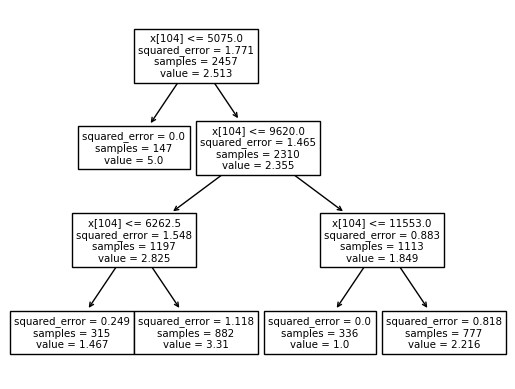

In [28]:
tree.plot_tree(model)

In [37]:
model.predict(X_train)

array([2.21621622, 2.21621622, 2.21621622, ..., 3.30952381, 3.30952381,
       3.30952381])

In [35]:
print(sklearn.metrics.mean_absolute_error(model.predict(X_test), y_test))


ValueError: Input contains NaN.

# Random forest 

In [169]:
#from sklearn.preprocessing import RobustScaler
#scaler = RobustScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [120]:
# Try different numbers of n_estimators - this will take a minute or so
#estimators = np.arange(10, 200, 10)
#scores = []
#model = RandomForestRegressor()
#for n in estimators:
 #   model.set_params(n_estimators=n)
  #  model.fit(X_train,y_train)
   # scores.append(model.score(X_test, y_test))
#plt.title("Effect of n_estimators")
#plt.xlabel("n_estimator")
#plt.ylabel("score")
#plt.plot(estimators, scores)

In [31]:
clf = RandomForestRegressor(n_estimators=100, random_state=0)
# fit the model to the training set
clf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [14]:
df_predict = pd.DataFrame([clf.predict(X_train),np.array(y_train),np.array(df[df['date'].isin(train_ids['date'])]['date'])]).T
df_predict.rename(columns={0:'prediction',1:'true',2:'date'},inplace=True)

In [32]:
clf.predict(X_train)

array([2., 2., 2., ..., 3., 3., 3.])

In [15]:
df_predict.groupby('date').mean()

,prediction,true
date,,
2023-11-06,2.0,2.0
2023-11-08,1.0,1.0
2023-11-10,3.0,3.0
2023-11-11,2.0,2.0
2023-11-12,2.0,2.0
2023-11-13,1.0,1.0
2023-11-14,3.0,3.0
2023-11-16,4.0,4.0
2023-11-17,1.0,1.0


<Axes: xlabel='date', ylabel='prediction'>

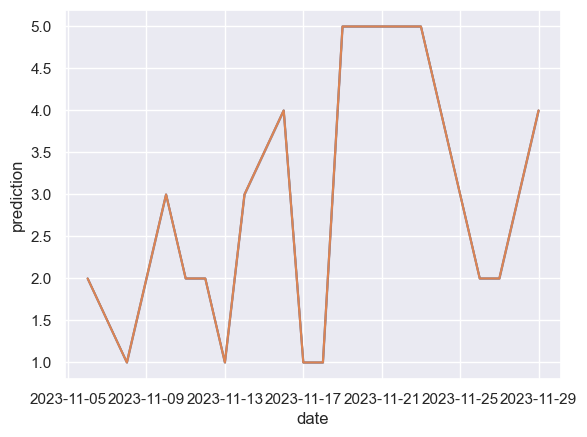

In [216]:
sns.lineplot(x='date', y='prediction', data=df_predict)
sns.lineplot(x='date', y='true', data=df_predict)

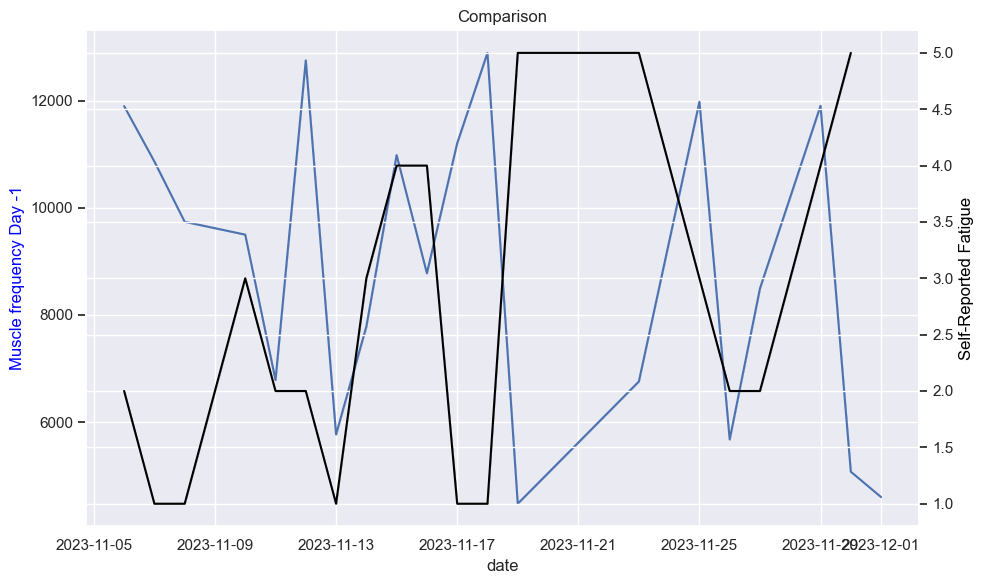

In [157]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))

# Plot the first line with the left y-axis
# dark blue line is late measurement
#ax1 = sns.lineplot(x='date', y='mean_median_freq', data=df, hue='muscle')
ax1 = sns.lineplot(x='date', y='pedometer', data=df)

# light blue line is early measurement
#ax1 = sns.lineplot(x='date', y='mean#_early_shift1', data=df_all, color='lightblue')

ax1.set_ylabel('Muscle frequency Day -1', color='blue')

# Create a secondary y-axis and plot the second line
ax2 = ax1.twinx()
sns.lineplot(x='date', y='fatigue_next_day', data=df, color='black', ax=ax2)
ax2.set_ylabel('Self-Reported Fatigue', color='black')

plt.title('Comparison')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index=feature_list).sort_values(ascending=False)
feature_scores

pedometer    1.0
0            0.0
69           0.0
80           0.0
79           0.0
            ... 
33           0.0
32           0.0
31           0.0
30           0.0
PM           0.0
Length: 110, dtype: float64

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_7509/2982877355.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_scores.index)


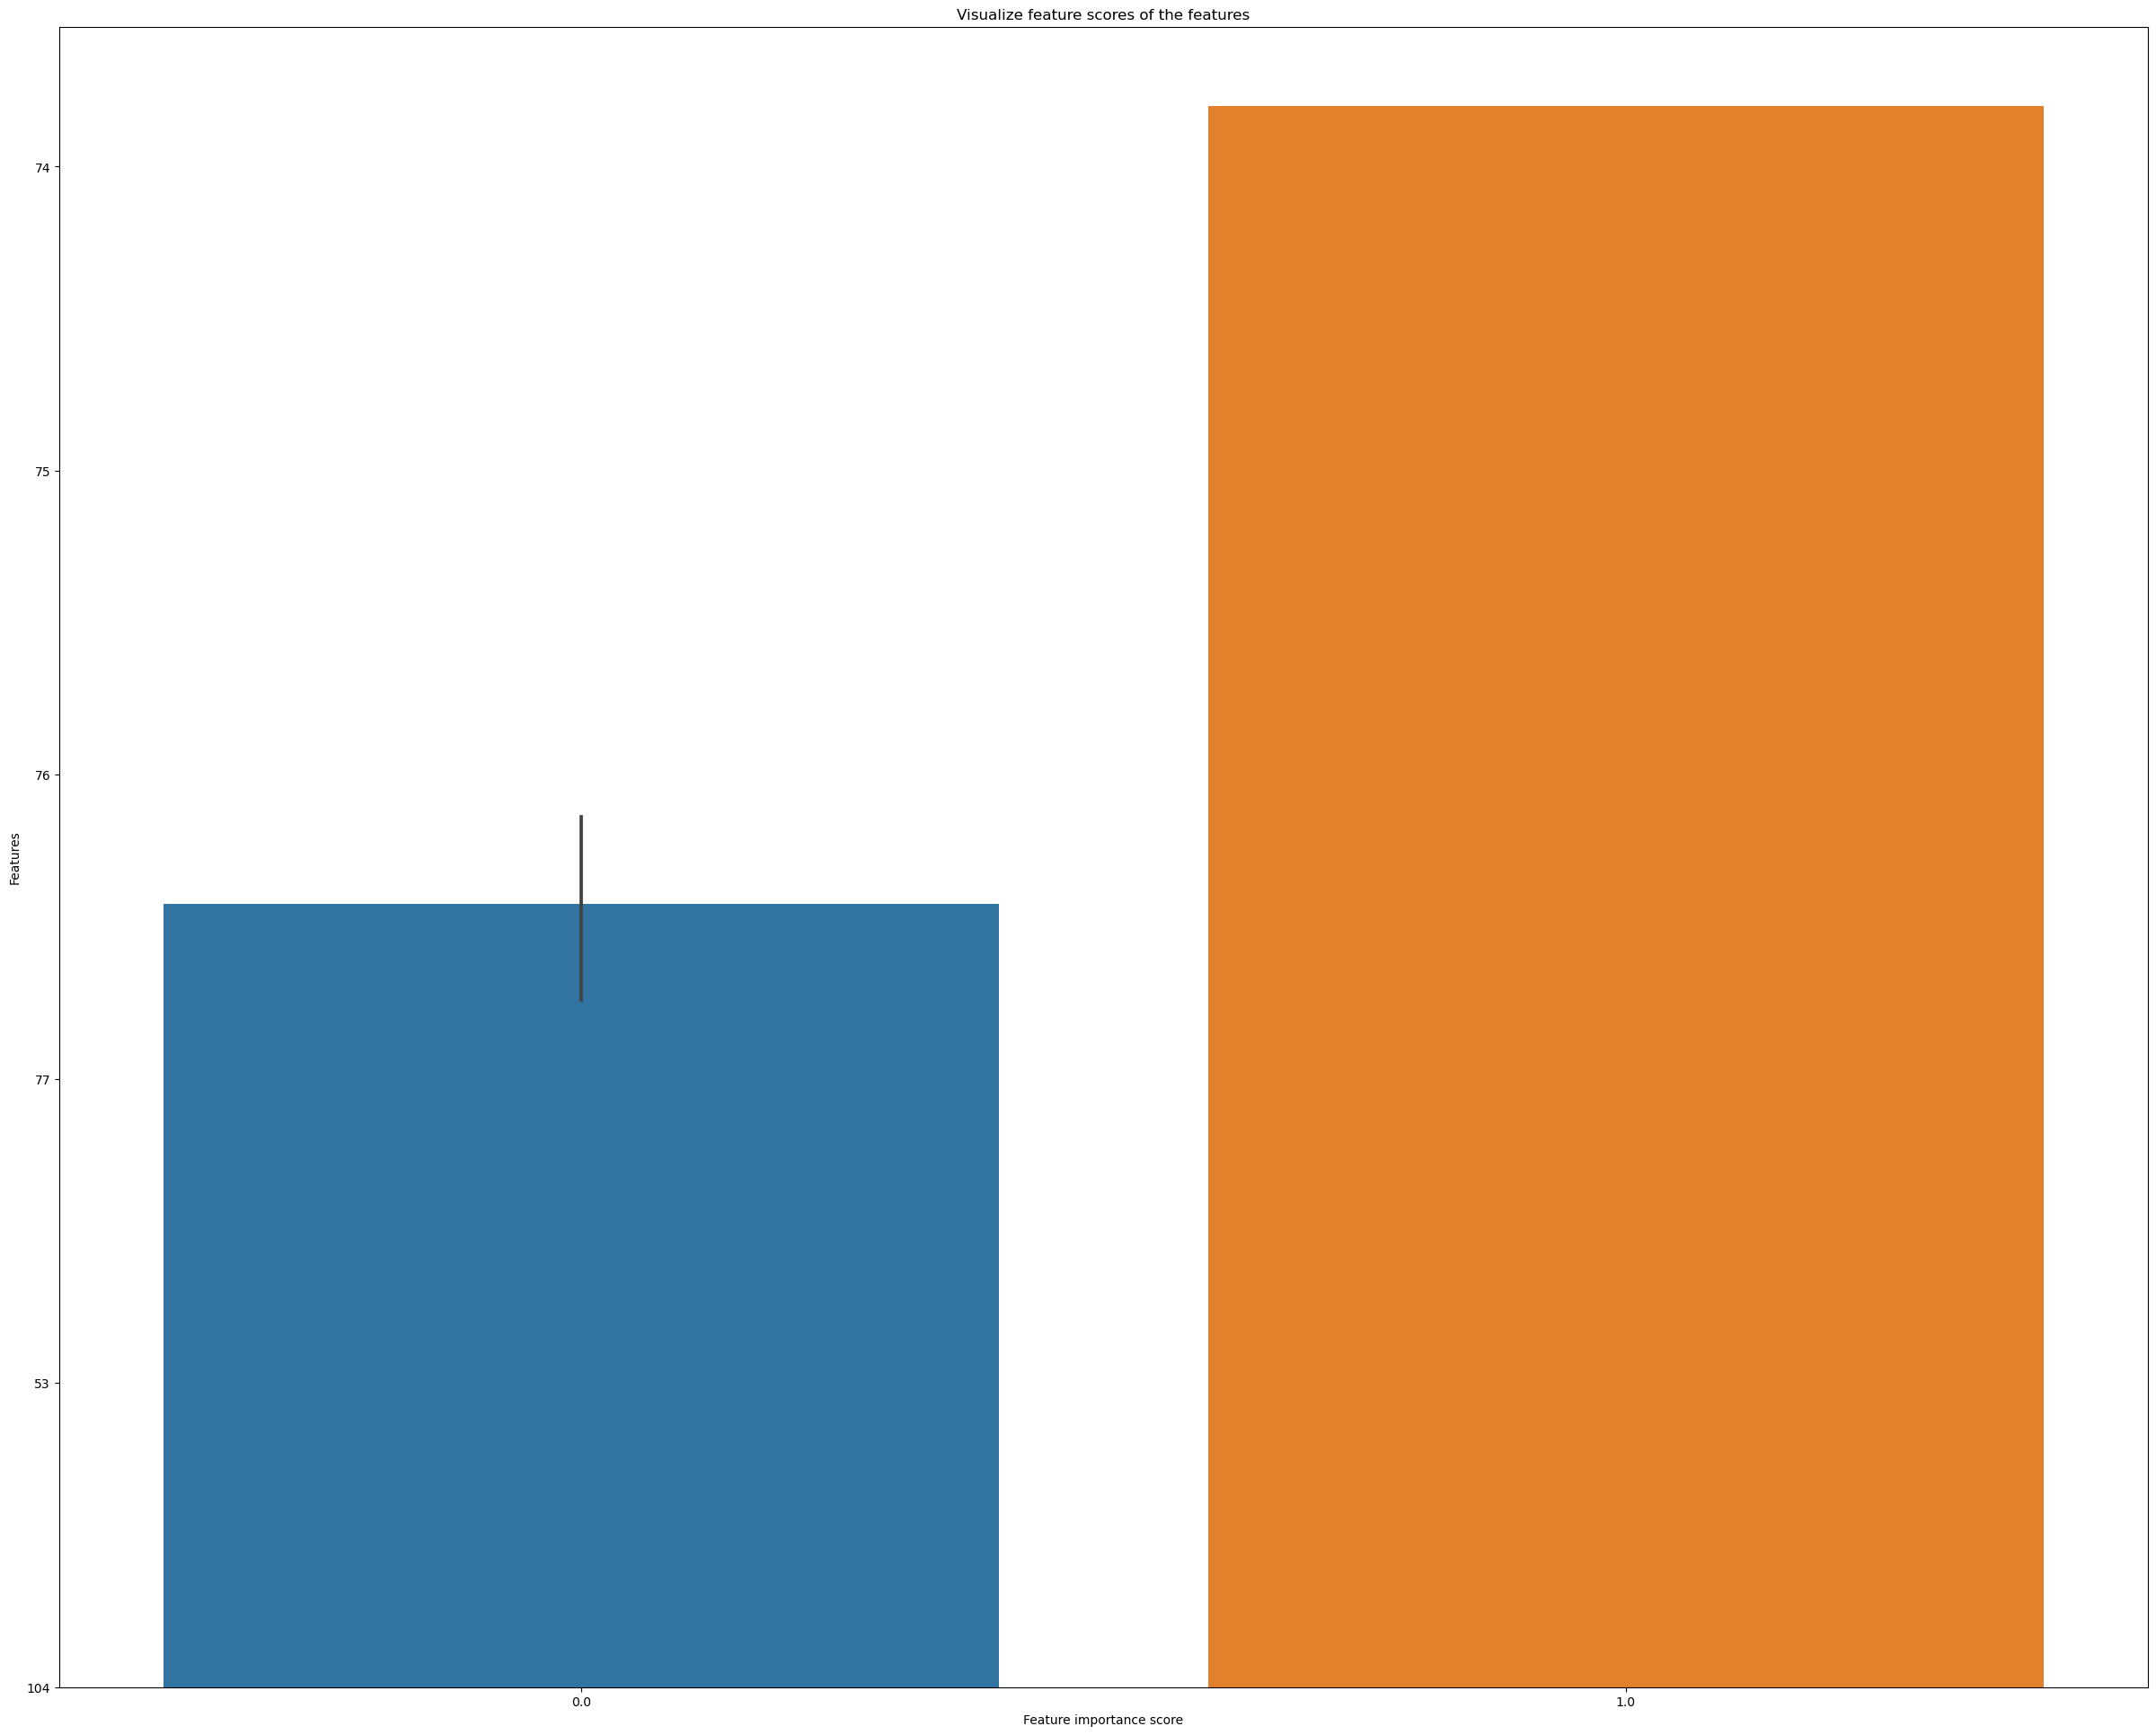

In [124]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [294]:
model.score(X, Y)

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


0.012475656950347025

In [295]:
np.abs(clf.predict(X_test) - Y_test)

105     1.678984
106     1.503903
107     1.486848
108     1.338138
109     1.209705
          ...   
2914    1.722346
2915    1.831230
2916    1.358355
2917    1.619856
2918    1.698228
Name: fatigue_next_day, Length: 378, dtype: float64

In [297]:
Y_test_agg = pd.concat([df_test,pd.Series(clf.predict(X_test),name='prediction')],axis=1).dropna().groupby('date')['prediction'].mean()
np.sum(np.abs(np.round(Y_test_agg) -df_test['fatigue_next_day'].unique())/Y_test_agg.shape[0])

1.6666666666666665

It seems whether its evening or not as well as the muscles are the most relevant predictors -> try subsets.

In [259]:
df_sub = df.dropna(subset=['fatigue_next_day'])
df_sub = df_sub[df_sub['date'].isin(train_ids['date'])]
df_sub = df_sub[df_sub['PM']==True]
df_sub = df_sub[df_sub['vastus_right']==True]


df_features = df_sub[[col for col in df_sub.columns if col.isdigit() and 0 <= int(col) <= 103]]
df_other_features = df_sub[['brachii_right','vastus_right','vastus_left','PM']]
X= pd.concat([df_features,df_other_features],axis=1)
Y= df_sub['fatigue_next_day']

In [211]:
clf = RandomForestRegressor(n_estimators=10, random_state=0)
# fit the model to the training set
clf.fit(X, Y)

RandomForestRegressor(n_estimators=10, random_state=0)

In [212]:
Y_test_agg = pd.concat([df_test,pd.Series(clf.predict(X_test),name='prediction')],axis=1).dropna().groupby('date')['prediction'].mean()
np.abs(np.round(Y_test_agg) -df_test['fatigue_next_day'].unique())

date
2023-11-07    2.0
2023-11-15    2.0
2023-11-30    1.0
Name: prediction, dtype: float64

In [213]:
# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_scores

83     0.115334
101    0.092263
37     0.064672
23     0.058859
11     0.053110
         ...   
71     0.000000
74     0.000000
77     0.000000
80     0.000000
PM     0.000000
Length: 108, dtype: float64

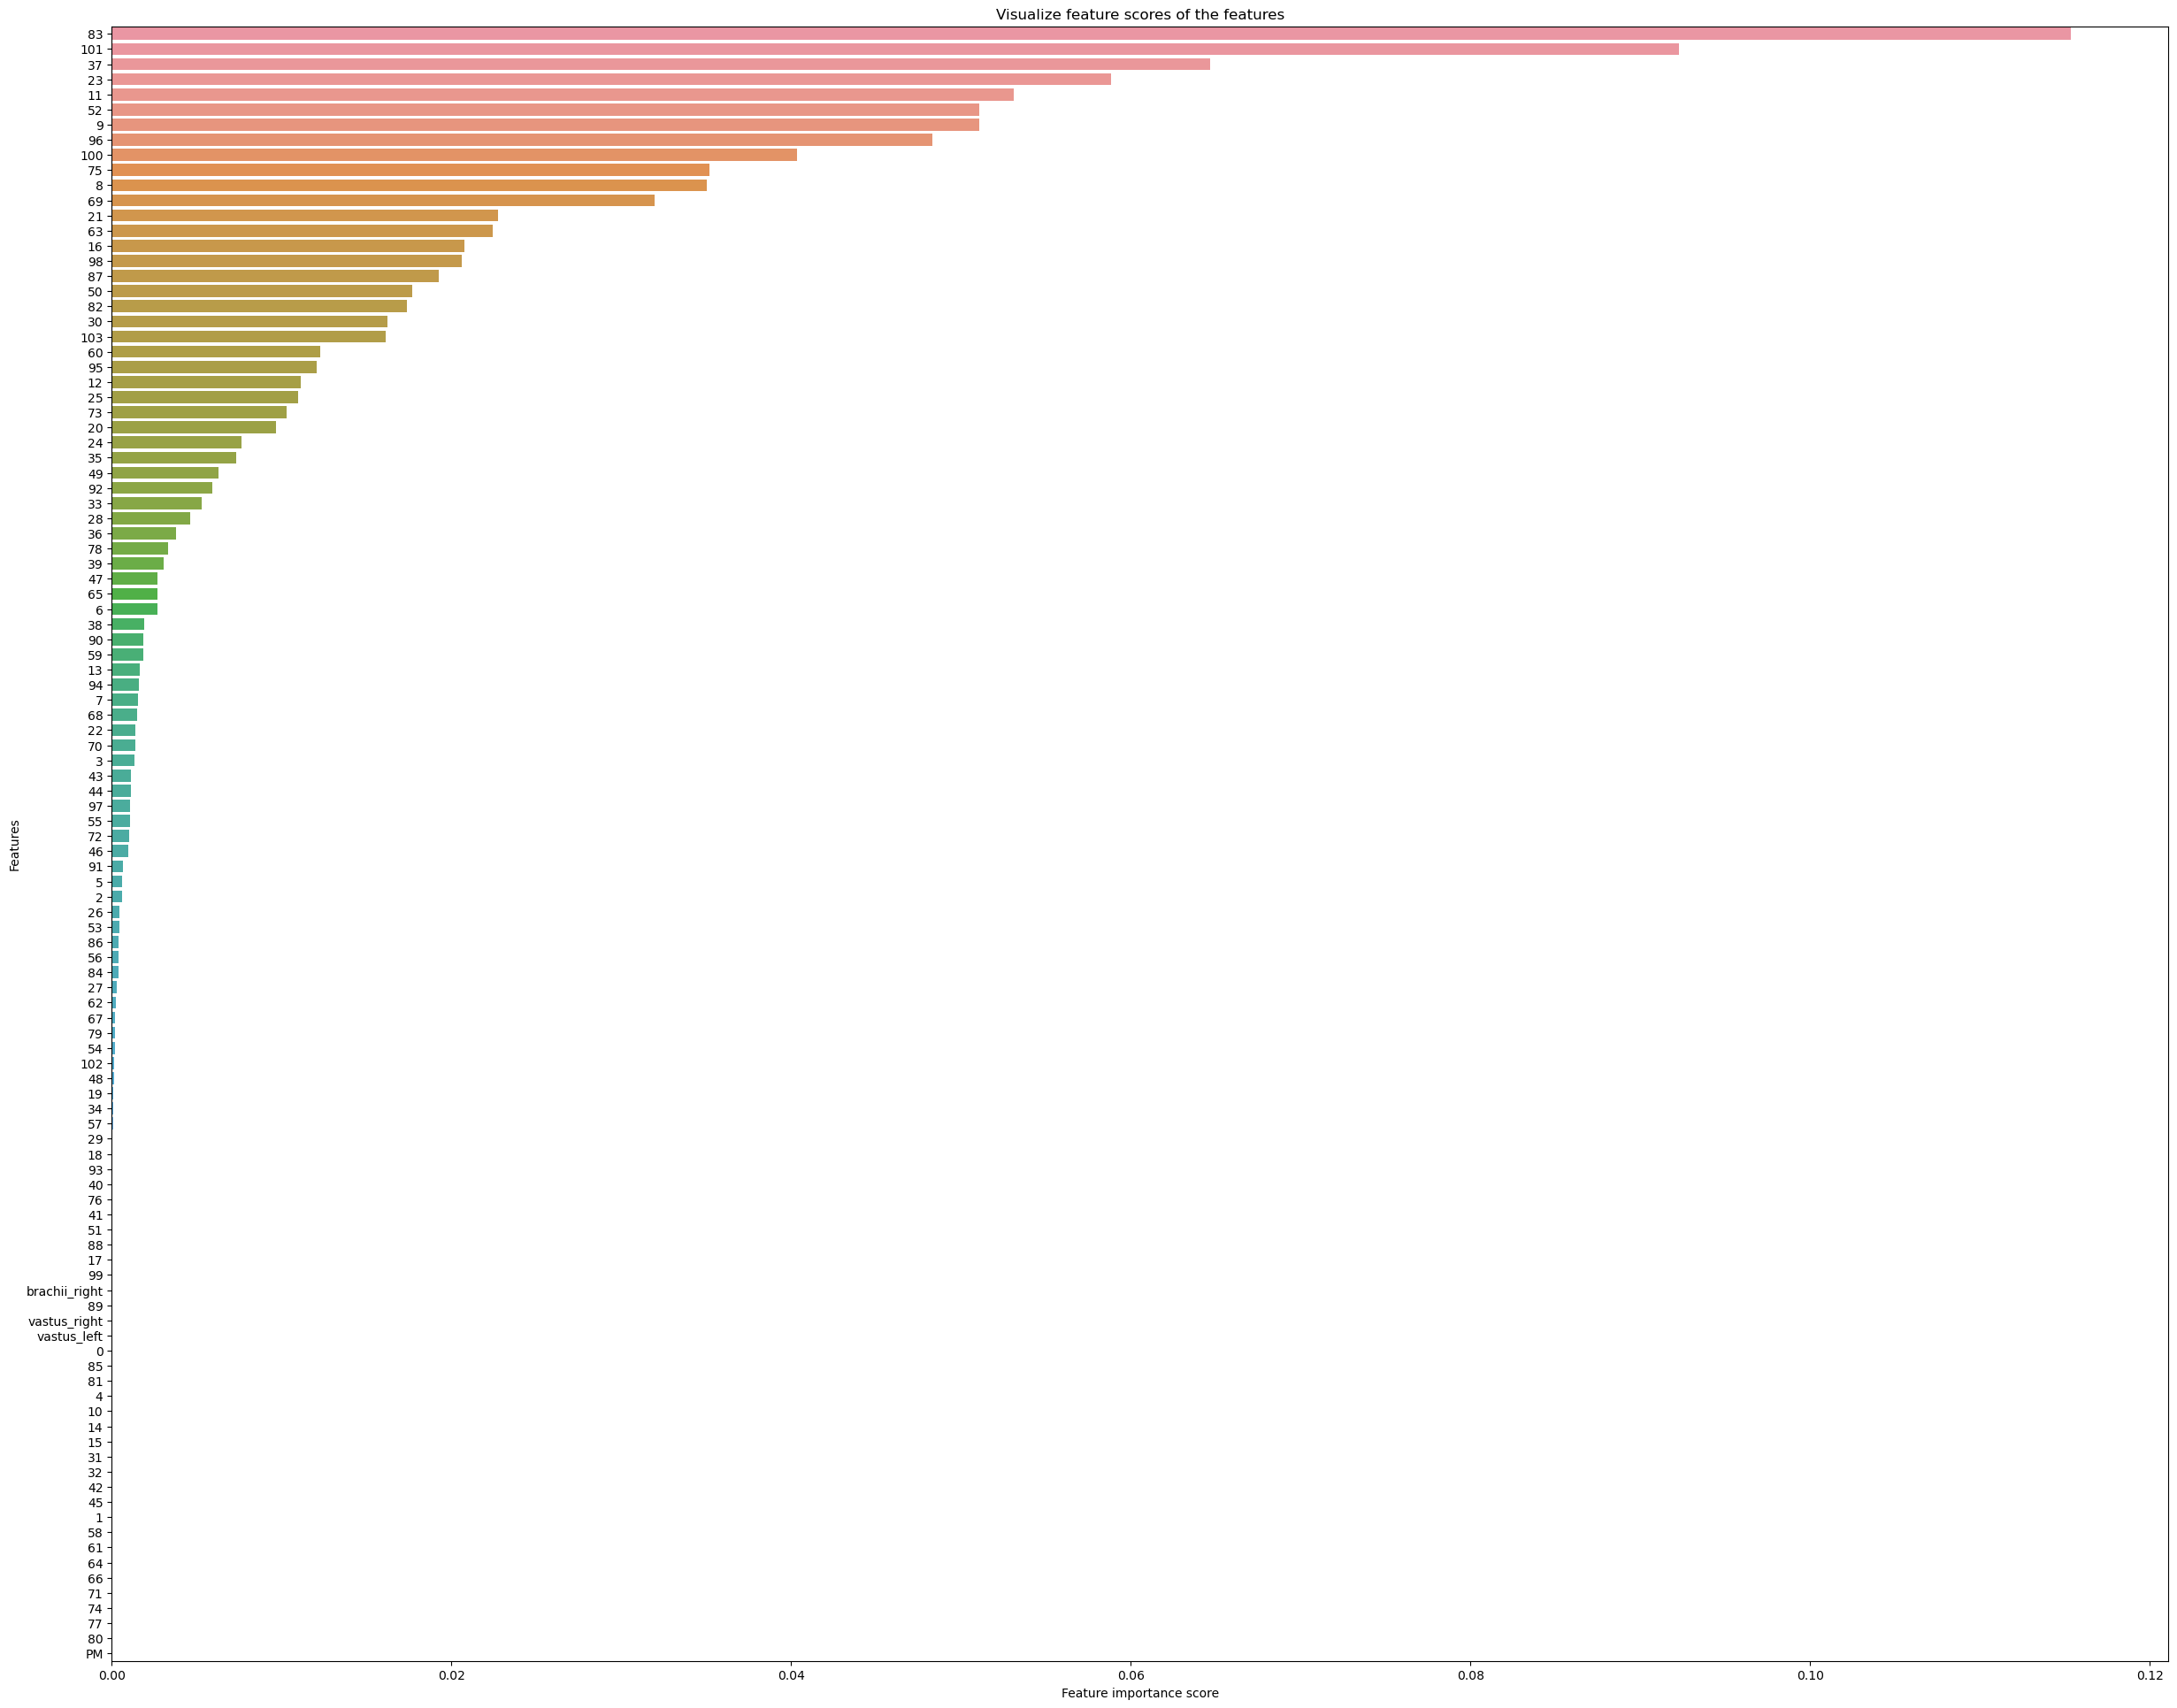

In [214]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

What if we do a classifier instead of regression?

In [215]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
# fit the model to the training set
clf.fit(X, Y)

RandomForestClassifier(n_estimators=10, random_state=0)

In [216]:
Y_test_agg = pd.concat([df_test,pd.Series(clf.predict(X_test),name='prediction')],axis=1).dropna(how='all').groupby('date')['prediction'].mean()
np.abs(np.round(Y_test_agg) -df_test['fatigue_next_day'].unique())

date
2023-11-07    1.0
2023-11-15    3.0
2023-11-30    2.0
Name: prediction, dtype: float64

In [217]:
np.abs(clf.predict(X_test) - Y_test)

105     4.0
106     1.0
107     1.0
108     1.0
109     1.0
       ... 
2914    2.0
2915    2.0
2916    2.0
2917    2.0
2918    2.0
Name: fatigue_next_day, Length: 378, dtype: float64

# Kefalas

In [336]:
features = pd.read_csv('/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self/data/features_kefalas.csv',index_col=0)

In [337]:
df = df_org[['id','brachii_right','vastus_right','vastus_left','PM','date']].merge(features, how='left',on='id')
df['date'] = pd.to_datetime(df['date'])

In [338]:
df = df.merge(df_labels[['date','fatigue_next_day']], how='left',on='date')

In [339]:
df_sub = df.dropna(subset=['fatigue_next_day'])
df_sub = df_sub[df_sub['date'].isin(train_ids['date'])]


In [347]:
X=pd.concat([df_sub.loc[:,'value__variance_larger_than_standard_deviation':'value__lempel_ziv_complexity__bins_100'],df_sub.loc[:,'brachii_right':'PM']],axis=1)
Y= df_sub['fatigue_next_day']

In [348]:
df_test = df.dropna(subset=['fatigue_next_day'])
df_test = df_test[df_test['date'].isin(test_ids['date'])]
X_test=pd.concat([df_test.loc[:,'value__variance_larger_than_standard_deviation':'value__lempel_ziv_complexity__bins_100'],df_test.loc[:,'brachii_right':'PM']],axis=1)
Y_test= df_test['fatigue_next_day']

In [353]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
# fit the model to the training set
clf.fit(X, Y)

RandomForestClassifier(n_estimators=10, random_state=0)

In [356]:
np.abs(clf.predict(X_test) - Y_test)

438      4.0
439      2.0
440      1.0
441      2.0
442      1.0
        ... 
11800    2.0
11801    2.0
11802    2.0
11803    2.0
11804    2.0
Name: fatigue_next_day, Length: 1534, dtype: float64

In [354]:
# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_scores

PM                                                                   0.130155
brachii_right                                                        0.097896
vastus_left                                                          0.079190
vastus_right                                                         0.076417
value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)         0.029966
                                                                       ...   
value__agg_autocorrelation__f_agg_"mean"__maxlag_40                  0.000000
value__agg_autocorrelation__f_agg_"median"__maxlag_40                0.000000
value__agg_autocorrelation__f_agg_"var"__maxlag_40                   0.000000
value__number_cwt_peaks__n_1                                         0.000000
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0    0.000000
Length: 222, dtype: float64

In [355]:
Y_test_agg = pd.concat([df_test,pd.Series(clf.predict(X_test),name='prediction')],axis=1).dropna().groupby('date')['prediction'].mean()
np.abs(np.round(Y_test_agg) -df_test['fatigue_next_day'].unique())

date
2023-11-07    1.0
2023-11-15    3.0
2023-11-30    2.0
Name: prediction, dtype: float64

tsfresh feature selection

In [418]:
df_sub = df.dropna(subset=['fatigue_next_day'])
df_sub = df_sub[df_sub['date'].isin(train_ids['date'])]
df_sub = df_sub[df_sub['PM']==True]
df_sub = df_sub[df_sub['vastus_right']==True]
X=pd.concat([df_sub.loc[:,'value__variance_larger_than_standard_deviation':'value__lempel_ziv_complexity__bins_100'],df_sub.loc[:,'brachii_right':'PM']],axis=1)

Y= df_sub['fatigue_next_day']

In [419]:
from tsfresh import select_features
X_selected = select_features(X, Y)

In [421]:
df_test = df.dropna(subset=['fatigue_next_day'])
df_test = df_test[df_test['date'].isin(test_ids['date'])]

df_test = df_test[df_test['PM']==True]
df_test = df_test[df_test['vastus_right']==True]
X_test=pd.concat([df_test.loc[:,'value__variance_larger_than_standard_deviation':'value__lempel_ziv_complexity__bins_100'],df_test.loc[:,'brachii_right':'PM']],axis=1)
Y_test= df_test['fatigue_next_day']

In [422]:
clf.fit(X_selected, Y)

RandomForestClassifier(n_estimators=10, random_state=0)

In [423]:
X_test = X_test.loc[:,X_test.columns[X_test.columns.isin(X_selected.columns)]]

In [424]:
# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index=X_selected.columns).sort_values(ascending=False)
feature_scores

value__quantile__q_0.8                                           0.057541
value__quantile__q_0.9                                           0.055885
value__quantile__q_0.4                                           0.053242
value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)    0.049150
value__quantile__q_0.2                                           0.049098
value__abs_energy                                                0.048842
value__maximum                                                   0.048338
value__sum_values                                                0.047701
value__median                                                    0.046424
value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)     0.046227
value__mean                                                      0.045854
value__fft_coefficient__attr_"abs"__coeff_0                      0.045807
value__quantile__q_0.3                                           0.045408
value__minimum                        

In [425]:
np.mean(np.abs(clf.predict(X_test[X_selected.columns])-Y_test))

1.6319018404907975

In [460]:
accuracy_score(Y_test, clf.predict(X_test[X_selected.columns]))

0.1656441717791411

In [459]:
Y_test_agg =pd.concat([df_test.reset_index(),pd.Series(clf.predict(X_test[X_selected.columns]),name='prediction')],  axis=1).dropna(how='all').groupby('date')['prediction'].mean()
np.abs(np.round(Y_test_agg) -df_test['fatigue_next_day'].unique())

date
2023-11-07    2.0
2023-11-15    1.0
Name: prediction, dtype: float64

# Afram, Sabet Baseline

In [276]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_new = scaler.transform(X)

In [277]:
from sklearn.feature_selection import SelectKBest, chi2
# perform feature selection using SelectKBest
feature_selector = SelectKBest(chi2, k=20).fit(X_new, Y)
X_new = feature_selector.transform(X_new)

In [278]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
# fit the model to the training set
clf.fit(X_new, Y)

RandomForestClassifier(n_estimators=10, random_state=0)

In [256]:
from sklearn.model_selection import RepeatedStratifiedKFold
def evaluate_model(model, X, y):
 # define the evaluation procedure
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 # evaluate the model and collect the results
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
 return scores

In [229]:
scores = evaluate_model(clf, X_new, Y)

In [230]:
scores

array([0.16666667, 0.16666667, 0.03333333, 0.13333333, 0.06896552,
       0.06896552, 0.06896552, 0.06896552, 0.        , 0.03448276,
       0.06666667, 0.16666667, 0.06666667, 0.1       , 0.13793103,
       0.03448276, 0.13793103, 0.06896552, 0.13793103, 0.10344828,
       0.16666667, 0.1       , 0.1       , 0.03333333, 0.13793103,
       0.06896552, 0.06896552, 0.03448276, 0.03448276, 0.13793103])

In [279]:
np.abs(clf.predict(feature_selector.transform(X_test)) - Y_test)

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


105     1.0
106     1.0
107     1.0
108     1.0
109     1.0
       ... 
2914    2.0
2915    2.0
2916    2.0
2917    2.0
2918    2.0
Name: fatigue_next_day, Length: 378, dtype: float64

In [280]:
clf.predict(feature_selector.transform(X_test))

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2., 2., 1., 2., 1., 1.,
       2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2.,
       1., 1., 2., 2., 1., 2., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 2., 1., 1., 2., 2., 1., 2., 1., 1., 2., 2., 2., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [241]:
Y_test_agg = pd.concat([df_test,pd.Series(clf.predict(feature_selector.transform(X_test)),name='prediction')],axis=1).dropna().groupby('date')['prediction'].mean()
np.abs(np.round(Y_test_agg) -df_test['fatigue_next_day'].unique())

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


date
2023-11-07    1.0
2023-11-15    3.0
2023-11-30    2.0
Name: prediction, dtype: float64